                                        ##############################
                                        #   **Cities Fingerprint**   #
                                        #         MODULE_DATA        #                                                  
                                        #                            #
                                        #   		  codename: k1   #
                                        #                            #
                                        #   version = 201605071607   #
                                        #    Issues known: none      #
                                        #                            #
                                        #   A script by AndresPDLR   #
                                        ##############################


    This program extracs the fingerprint of a urban landscape according 
    to the method exposed in A typology of Street Patterns by Rémi Louf,
    Marc Barthelemy (ATSP)
    
        http://bit.ly/1QZ83IK


    - It assumes the existence of CSV files produced by MODULE_GIS
    - Produces the key variable from ATSP called Φ for each block

**Definitions used in ATSP**

    A  = Area of the block
    AC = Area of the circumscribed circle C
    Φ  = A/AC
    P(Φ) Distribution

**Useful spanish~english translations**

    manzana = spanish for block
    edo = spanish acronym for state

<div class="alert alert-success">
**Requirements**

</div>

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import math as mt

import datetime

import ast

from sys import argv
import csv

import os
from simpledbf import Dbf5

import scipy

from localidades_100k import localidades_100k_dictionary
from localidades import localidades_dictionary

from functools import partial
import networkx as nx

In [12]:
edo_codes = {'01':  'ags', '02':  'bc', '03':  'bcs', '04':  'camp',
             '05': 'coah', '06': 'col', '07': 'chis', '08':  'chih',
             '09':   'df', '10': 'dgo', '11':  'gto', '12':   'gro',
             '13':  'hgo', '14': 'jal', '15':  'mex', '16':  'mich',
             '17':  'mor', '18': 'nay', '19':   'nl', '20':   'oax',
             '21':  'pue', '22': 'qro', '23': 'qroo', '24':   'slp',
             '25':  'sin', '26': 'son', '27':  'tab', '28': 'tamps',
             '29': 'tlax', '30': 'ver', '31':  'yuc', '32':   'zac'}

edos = ["ags",  "bc", "bcs",  "camp", "coah", "col", "chis", "chih",
        "df" , "dgo", "gro",   "gto",  "hgo", "jal",  "mex", "mich",
        "mor", "nay",  "nl",   "oax",  "pue", "qro", "qroo",  "slp",
        "sin", "son", "tab", "tamps", "tlax", "ver",  "yuc",  "zac"]

<div class="alert alert-success">
**Functions**
</div>

In [13]:
def de_string_list(list_as_string):
    ''' 
    >> Transform string representation of list to list
    
    Input:
        - list as a string
    
    Output:
        - list as list
    '''
    if type(list_as_string) != list:
        try:
            list_as_list = ast.literal_eval(list_as_string)
            return list_as_list
        except ValueError:
            return list_as_string
    else:
        return list_as_string

In [14]:
def dbf_to_csv(location, file):
    '''
    >> Convert dbf files into csv
    
    Input:
        - path location
        - name of dbf file
    
    Output:
        - csv file storaged in location
    '''  
    directory = os.listdir(location)
    dbf_file = Dbf5(file)
    dbf_file.to_csv(file[:-3] + 'csv')
    print('file ' + file + ' ready!')

In [15]:
def euclidean_distance(p1, p2):
    '''
    >> Calculates euclidiean distance between two points
    
    Input:
        - points as lists or tuples
    
    Output:
        - euclidean distance as float 
    '''
    x_1 = p1[0]
    y_1 = p1[1]
    x_2 = p2[0]
    y_2 = p2[1]
    distance = mt.sqrt(pow((x_2-x_1), 2) + pow((y_2-y_1), 2))
    return distance

In [16]:
def circumscribed_circle_area(center, node_list):
    '''
    >> From a list of nodes, calculates circumscribed circle area
    
    Input:
        - center
        - list of nodes
    
    Output:
        - area as float
    '''
    distances = []
    for n in node_list:
        distance = euclidean_distance(center, n)
        distances.append(distance)
    radius = max(distances)
    Ac = mt.pi * pow(radius, 2)
    return Ac

In [17]:
def Φ_function(edo):
    '''
    >> Returns Ac and Φ, which lives between 0 & 1
       "The smaller its the value, the more anisotropic the block is" (ATSP)
    
    Input:
        - edo code
    
    Output:
        - csv storaged in parent directory
    '''
    print(edo + " started at ", datetime.datetime.now().isoformat())
    Φ_dictionary = {}
    Ac_dictionary = {}

    # Loading Data
    areas = pd.read_csv('k1_areas_{}.csv'.format(edo), header=None, names=['Manzanas', 'Area'])
    centroid_coordinates = pd.read_csv('k1_centroid_coordinates_{}.csv'.format(edo), header=None, names=['Manzanas', 'Centroid Coordinates'])
    nodes_coordinates = pd.read_csv('k1_nodes_coordinates_{}.csv'.format(edo), header=None, names=['Manzanas', 'Nodes Coordinates'])
    
    # Extracting information
    for m in areas['Manzanas']:
        A = areas.loc[areas['Manzanas'] == m]['Area'].values[0]
        centroid = centroid_coordinates.loc[centroid_coordinates['Manzanas'] == m]['Centroid Coordinates'].values[0]
        nodes = nodes_coordinates.loc[nodes_coordinates['Manzanas'] == m]['Nodes Coordinates'].values[0]
        center = de_string_list(centroid)
        node_list = de_string_list(nodes)
        Ac = circumscribed_circle_area(center, node_list)
        Φ = A / Ac
        Φ_dictionary[m] = Φ
        Ac_dictionary[m] = Ac
    
    # Storing information
    writer_Φ = csv.writer(open('C:/Users/Andres/k1_Output_{}.csv'.format(edo), 'w', newline=''))
    for manzana, value in Φ_dictionary.items():
        writer_Φ.writerow([str(manzana), value])
        
    writer_Ac = csv.writer(open('C:/Users/Andres/k1_Ac_{}.csv'.format(edo), 'w', newline=''))
    for manzana, value in Ac_dictionary.items():
        writer_Ac.writerow([str(manzana), value])
    
    print(edo + " completed at ", datetime.datetime.now().isoformat())
        

In [18]:
def explore(edo):
    ''' 
    >> Plots a series of charts and returns merge dataframe with all relevant information
    
    Input:
        - edo code
    
    Output:
        - dataframe & plots
    '''
    areas = pd.read_csv('k1_areas_{}.csv'.format(edo), header=None, names=['Manzanas', 'Area'])
    centroid_coordinates = pd.read_csv('k1_centroid_coordinates_{}.csv'.format(edo), header=None, names=['Manzanas', 'Centroid Coordinates'])
    nodes_coordinates = pd.read_csv('k1_nodes_coordinates_{}.csv'.format(edo), header=None, names=['Manzanas', 'Nodes Coordinates'])
    Ac = pd.read_csv('k1_Ac_{}.csv'.format(edo), header=None, names=['Manzanas', 'Ac'])
    Φ = pd.read_csv('k1_Output_{}.csv'.format(edo), header=None, names=['Manzanas', 'Φ'])
    edo_all = areas.merge(Φ, left_on = 'Manzanas', right_on='Manzanas')
    edo_all = edo_all.merge(Ac, left_on = 'Manzanas', right_on='Manzanas')
    areas.plot(figsize=(18,6), color = 'blue', alpha = .5)
    edo_all.plot(kind='scatter', x='Φ', y='Area', color = "red", alpha = .10, figsize=(18,10), xlim = (0, 1), ylim = (0, .000001))
    Φ.plot(kind = 'kde', figsize=(18,6), color = 'blue', alpha = .5)

In [19]:
def load_data(edo):
    ''' 
    >> Loads edo data and returns merge dataframe with all relevant information
    
    Input:
        - edo code
    
    Output:
        - dataframe
    '''
    areas = pd.read_csv('k1_areas_{}.csv'.format(edo), header=None, names=['Manzanas', 'Area'])
    centroid_coordinates = pd.read_csv('k1_centroid_coordinates_{}.csv'.format(edo), header=None, names=['Manzanas', 'Centroid Coordinates'])
    nodes_coordinates = pd.read_csv('k1_nodes_coordinates_{}.csv'.format(edo), header=None, names=['Manzanas', 'Nodes Coordinates'])
    Ac = pd.read_csv('k1_Ac_{}.csv'.format(edo), header=None, names=['Manzanas', 'Ac'])
    Φ = pd.read_csv('k1_Output_{}.csv'.format(edo), header=None, names=['Manzanas', 'Φ'])
    edo_all = areas.merge(Φ, left_on = 'Manzanas', right_on='Manzanas')
    edo_all = edo_all.merge(Ac, left_on = 'Manzanas', right_on='Manzanas')
    print('{} has been loaded!'.format(edo))
    return edo_all

In [20]:
def slice_code(length, code):
    '''
    >> Returns trimmed string at a certain length
    
    Input:
        - desired length
        - string code
    
    Output:
        - 
    '''
    rv_code = code[0:length]
    return rv_code

In [21]:
def region_creator(region):
    ''' 
    >> Creates a dataframe of a region
    
    Input:
        - region code according to:
        
            Region Level |    Instance    | Lenght 
            ---------------------------------------
                Estado   |       01       |   2
            ---------------------------------------
              Municipio  |      01001     |   5
            ---------------------------------------
              Localidad  |    010010001   |   9
            ---------------------------------------
                AGEB     |  0100100014325 |   13
    
    Output:
        - region dataframe
    
    '''
    region_types = {2: 'Estados', 5: 'Municipios', 9: 'Localidades', 13: 'AGEBs'}
    if len(region) not in region_types:
        print('Not a Region!')
    else:
        edo_code = region[0:2] # extract edo_code
        edo = edo_codes[edo_code] # determine the edo
        df = load_data(edo) # load relevant data
        region_type = region_types[len(region)]
        slice_region = partial(slice_code, len(region))
        df[region_type] = df['Manzanas'].apply(slice_region)
        df_region = df.loc[df[region_type] == region] # loc to the region
        return df_region

In [22]:
def city_distance(city_1, city_2):
    '''
    >> Calculates <distance> as defined in ATSP between two city street patterns 
    
    Input:
        - regions (cities) dataframes
    
    Output:
        - float with <distance> 
    
    '''
    bins = [(0, 2e-07), (2e-07, 4e-07), (4e-07, 6e-07), (6e-07, 8e-07), (8e-07, 1)]
    manzanas_1 = len(city_1)
    manzanas_2 = len(city_2)
    distances = []
    for alpha in bins:
        city_1_alpha = city_1.loc[(city_1['Area'] > alpha[0]) & (city_1['Area'] < alpha[1])]
        city_2_alpha = city_2.loc[(city_2['Area'] > alpha[0]) & (city_2['Area'] < alpha[1])]
        f_1_alpha = city_1_alpha['Area'].sum() / manzanas_1
        f_2_alpha = city_2_alpha['Area'].sum() / manzanas_2
        distance = pow(abs(f_1_alpha - f_2_alpha), 2)
        distances.append(distance)
    DISTANCE = sum(distances)
    return DISTANCE

In [69]:
def analyze_region(region):
    '''
    >> It produces summary statistics for a region's block structure
    
    Input:
        - region code
    Output:
        - stats over Φ, A & Ac
        - scatter plot A ~ Φ
        - histogram over Φ saved as image 
    '''
    rv = {}
    df = region_creator(region)
    mean_Area = df['Area'].mean()
    mean_Ac = df['Ac'].mean()
    mean_Φ = df['Φ'].mean()
    rv['Mean A'] = mean_Area
    rv['Mean Ac'] = mean_Ac
    rv['Mean Φ'] = mean_Φ
    df.plot(kind = 'scatter', x = 'Φ', y = 'Area', c = 'b', s = 10, alpha = 1, figsize = (18,10), xlim = (0, 1), ylim = (0, 1e-06))
    filename = 'myplot'
    plt.savefig(filename + '.pdf',format = 'pdf', transparent=True)
    #df['Φ'].plot(kind = 'kde', color = 'blue',  figsize=(18,10), xlim = (0, 1))

ags has been loaded!


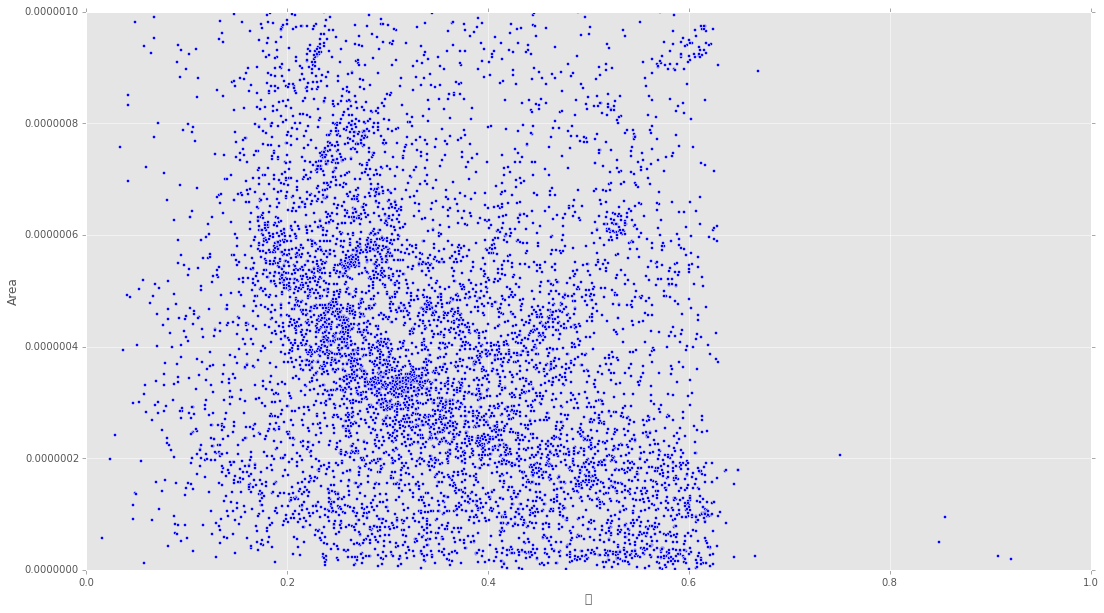

In [70]:
# Testing
region = '010010001'
analyze_region(region)

<div class="alert alert-success">
**Data Analysis ALL EDOS**
</div>

In [20]:
# call all the 32 states into dataframes:
ags = load_data('ags')      # 01
bc = load_data('bc')        # 02
bcs = load_data('bcs')      # 03
camp = load_data('camp')    # 04
coah = load_data('coah')    # 05
col = load_data('col')      # 06
chis = load_data('chis')    # 07
chih = load_data('chih')    # 08
df = load_data('df')        # 09
dgo = load_data('dgo')      # 10
gto = load_data('gto')      # 11   
gro = load_data('gro')      # 12
hgo = load_data('hgo')      # 13
jal = load_data('jal')      # 14
mex = load_data('mex')      # 15
mich = load_data('mich')    # 16
mor = load_data('mor')      # 17
nay = load_data('nay')      # 18
nl = load_data('nl')        # 19
oax = load_data('oax')      # 20
pue = load_data('pue')      # 21
qro = load_data('qro')      # 22
qroo = load_data('qroo')    # 23
slp = load_data('slp')      # 24
sin = load_data('sin')      # 25
son = load_data('son')      # 26
tab = load_data('tab')      # 27
tamps = load_data('tamps')  # 28
tlax = load_data('tlax')    # 29
ver = load_data('ver')      # 30
yuc = load_data('yuc')      # 31
zac = load_data('zac')      # 32

ags has been loaded!
bc has been loaded!
bcs has been loaded!
camp has been loaded!
coah has been loaded!
col has been loaded!
chis has been loaded!
chih has been loaded!
df has been loaded!
dgo has been loaded!
gto has been loaded!
gro has been loaded!
hgo has been loaded!
jal has been loaded!
mex has been loaded!
mich has been loaded!
mor has been loaded!
nay has been loaded!
nl has been loaded!
oax has been loaded!
pue has been loaded!
qro has been loaded!
qroo has been loaded!
slp has been loaded!
sin has been loaded!
son has been loaded!
tab has been loaded!
tamps has been loaded!
tlax has been loaded!
ver has been loaded!
yuc has been loaded!
zac has been loaded!


In [21]:
# create dataframe_all for all states (entire Mexico) 

edos_dataframes = [ags,  bc, bcs,  camp, coah, col, chis, chih,
                   df,  dgo, gro,   gto,  hgo, jal,  mex, mich,
                   mor, nay,  nl,   oax,  pue, qro, qroo,  slp,
                   sin, son, tab, tamps, tlax, ver,  yuc,  zac]

dataframe_all = pd.concat(edos_dataframes)

In [22]:
dataframe_all.head()

,Manzanas,Area,Φ,Ac
0,0100100014325009,1.514624e-06,0.159168,9.515873e-06
1,0100100014325008,1.833420e-07,0.224965,8.149784e-07
2,0100100014325005,8.994317e-07,0.187952,4.785435e-06
3,0100100014325004,8.021103e-07,0.196058,4.091192e-06
4,0100100014325007,6.534422e-07,0.303527,2.152833e-06


In [23]:
# Number of blocks in Mexico
len(dataframe_all)

1456596

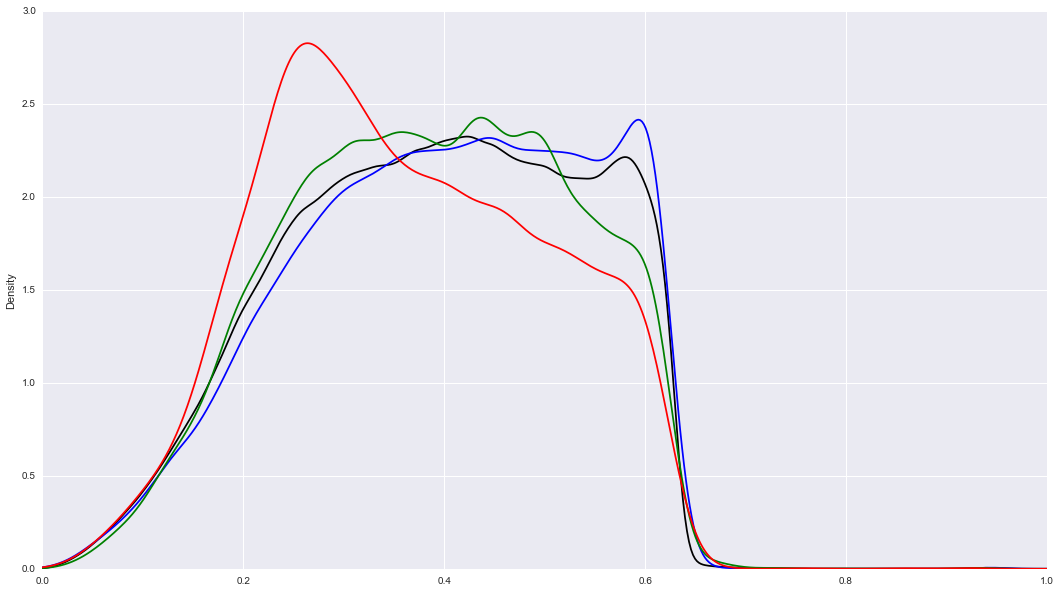

In [54]:
# Compare a region (instances = [ags, df, mich]) with national overall distribution
dataframe_all['Φ'].plot(kind = 'kde', color = 'black', figsize=(18,10), xlim = (0, 1))
mich['Φ'].plot(kind = 'kde', color = 'blue', figsize=(18,10), xlim = (0, 1))
df['Φ'].plot(kind = 'kde', color = 'green', figsize=(18,10), xlim = (0, 1))
ags['Φ'].plot(kind = 'kde', color = 'red', figsize=(18,10), xlim = (0, 1))

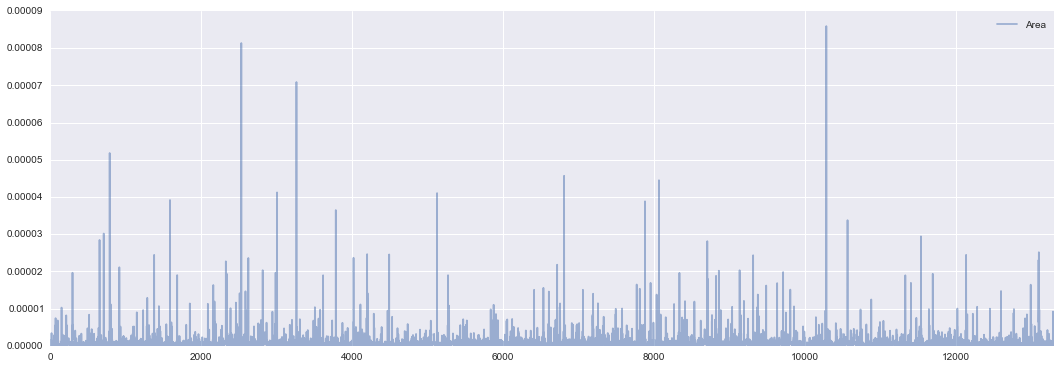

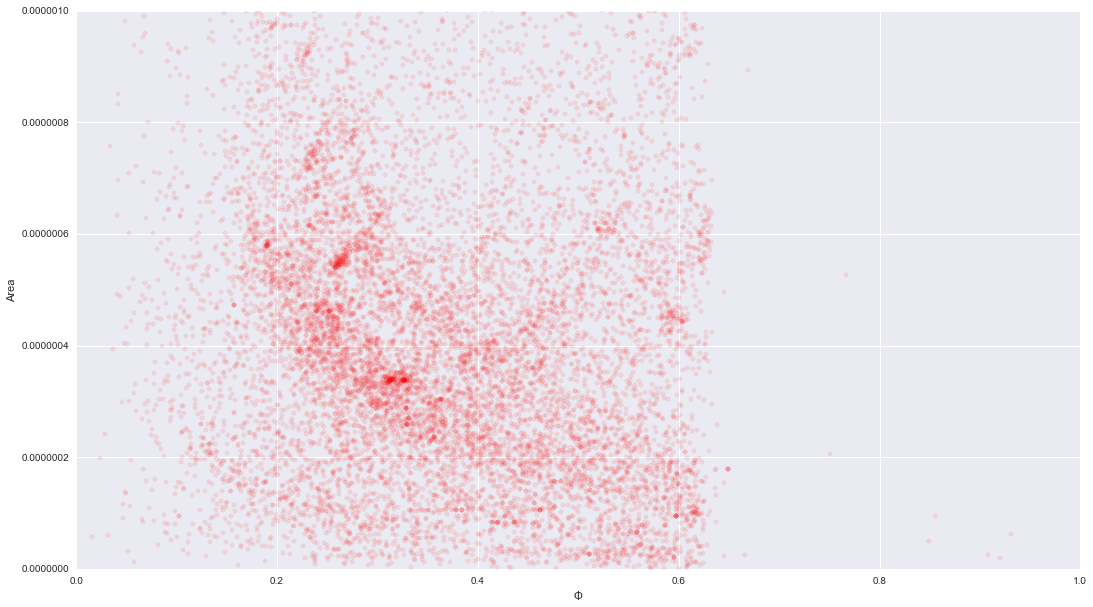

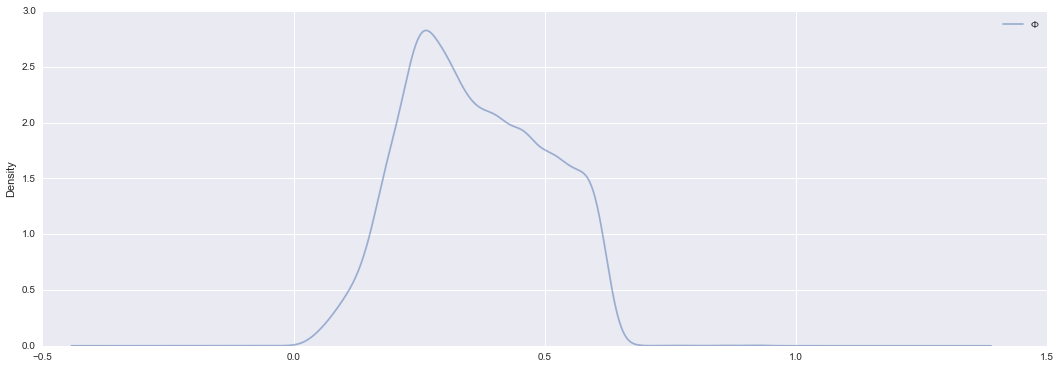

In [59]:
# Instance state of ags  
explore('ags')

In [ ]:
city_distance(city_1, city_2)

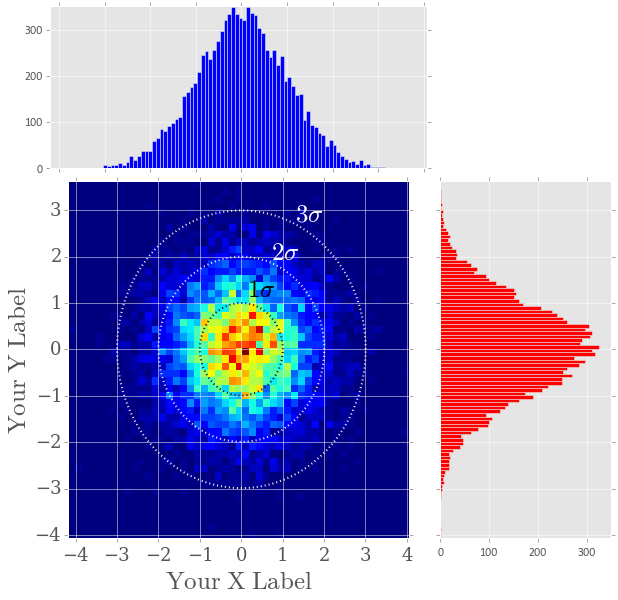

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, MaxNLocator
from numpy import linspace
plt.ion()
 
# Define a function to make the ellipses
def ellipse(ra,rb,ang,x0,y0,Nb=100):
    xpos,ypos=x0,y0
    radm,radn=ra,rb
    an=ang
    co,si=np.cos(an),np.sin(an)
    the=linspace(0,2*np.pi,Nb)
    X=radm*np.cos(the)*co-si*radn*np.sin(the)+xpos
    Y=radm*np.cos(the)*si+co*radn*np.sin(the)+ypos
    return X,Y
 
# Define the x and y data 
# For example just using random numbers
x = np.random.randn(10000)
y = np.random.randn(10000)
 
# Set up default x and y limits
xlims = [min(x),max(x)]
ylims = [min(y),max(y)]
 
# Set up your x and y labels
xlabel = '$\mathrm{Your\\ X\\ Label}$'
ylabel = '$\mathrm{Your\\ Y\\ Label}$'
 
# Define the locations for the axes
left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width+0.02
 
# Set up the geometry of the three plots
rect_temperature = [left, bottom, width, height] # dimensions of temp plot
rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram
 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
axHistx = plt.axes(rect_histx) # x histogram
axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(y)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 50
nybins = 50
nbins = 100
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = 1.0*(xmax - 0)/(1.0*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins))
X = xcenter
Y = ycenter
Z = H
 
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],
       interpolation='nearest', origin='lower',aspect=aspectratio))
 
# Plot the temperature plot contours
contourcolor = 'white'
xcenter = np.mean(x)
ycenter = np.mean(y)
ra = np.std(x)
rb = np.std(y)
ang = 0
 
X,Y=ellipse(ra,rb,ang,xcenter,ycenter)
axTemperature.plot(X,Y,"k:",ms=1,linewidth=2.0)
axTemperature.annotate('$1\\sigma$', xy=(X[15], Y[15]), xycoords='data',xytext=(10, 10),
                       textcoords='offset points', horizontalalignment='right',
                       verticalalignment='bottom',fontsize=25)
 
X,Y=ellipse(2*ra,2*rb,ang,xcenter,ycenter)
axTemperature.plot(X,Y,"k:",color = contourcolor,ms=1,linewidth=2.0)
axTemperature.annotate('$2\\sigma$', xy=(X[15], Y[15]), xycoords='data',xytext=(10, 10),
                       textcoords='offset points',horizontalalignment='right',
                       verticalalignment='bottom',fontsize=25, color = contourcolor)
 
X,Y=ellipse(3*ra,3*rb,ang,xcenter,ycenter)
axTemperature.plot(X,Y,"k:",color = contourcolor, ms=1,linewidth=2.0)
axTemperature.annotate('$3\\sigma$', xy=(X[15], Y[15]), xycoords='data',xytext=(10, 10),
                       textcoords='offset points',horizontalalignment='right',
                       verticalalignment='bottom',fontsize=25, color = contourcolor)
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=25)
axTemperature.set_ylabel(ylabel,fontsize=25)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(18)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(18)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
axHistx.hist(x, bins=xbins, color = 'blue')
axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
#Set up the histogram limits
axHistx.set_xlim( min(x), max(x) )
axHisty.set_ylim( min(y), max(y) )
 
#Make the tickmarks pretty
ticklabels = axHistx.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(12)
    label.set_family('serif')
 
#Make the tickmarks pretty
ticklabels = axHisty.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(12)
    label.set_family('serif')
 
#Cool trick that changes the number of tickmarks for the histogram axes
axHisty.xaxis.set_major_locator(MaxNLocator(4))
axHistx.yaxis.set_major_locator(MaxNLocator(4))
 
#Show the plot
plt.draw()

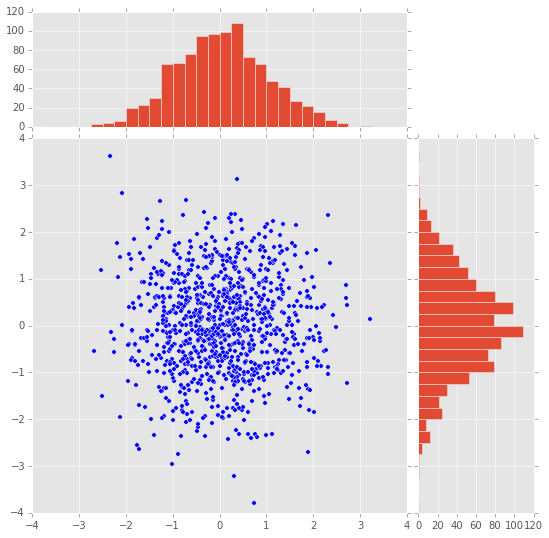

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()